In [16]:
import numpy as np
import scanpy as sc

## Load the count matrix

In [17]:
groups = ["Cortex", "PBMC"]
g = groups[1]

In [18]:
mtx = sc.read_mtx(g + "/matrix.mtx").transpose()

In [19]:
cells = []
with open(groups[1] + "/barcodes.tsv") as file:
    for line in file:
        cells.append(line.strip())

genes = []
with open(groups[1] + "/genes.tsv") as file:
    for line in file:
        genes.append(line.strip())

In [20]:
import pandas as pd

In [21]:
cell_df = pd.DataFrame(cells)
cell_df.index = cell_df[0]
cell_df = cell_df.drop(0, axis=1)
gene_df = pd.DataFrame(genes)
gene_df.index = gene_df[0]
gene_df = gene_df.drop(0, axis=1)
mtx.obs = cell_df
mtx.var = gene_df

In [22]:
mtx.obs["Experiment"] = [cell.split('.')[0] for cell in cells]
mtx.obs["Technology"] = [cell.split('.')[1] for cell in cells]

## Load marker gene data

In [23]:
import feather
markers = feather.read_dataframe(g + '/' + g + "_markers.feather")

/u/home/l/luke0321/nobackup-WGSPD/anaconda3/lib/python3.7/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [24]:
def remove_trailing_nums(cell_types):
    result = []
    for item in cell_types:
        for i in range(len(item) - 1, 0, -1):
            if not item[i].isdigit():
                result.append(item[:i + 1])
                break
    return result

In [25]:
markers["Cell type"] = remove_trailing_nums(markers["Cell type"])

In [53]:
cell_type_genes = {}
for t in markers["Cell type"].unique():
    # Only use upregulated markers for now
    cell_type_genes[t] = [item[:-1] for item in list(markers[markers["Cell type"] == t]["m"]) if item[-1] == '+']

## Check the clustering and annotate each cluster with marker genes

In [27]:
from sklearn.metrics import roc_auc_score

In [47]:
def annotate_clusters(cells, marker_genes, groupby="louvain"):
    clusters = cells.obs["louvain"].unique()
    cell_types = [t for t in marker_genes]
    cell_type_scores = np.zeros((cells.shape[0], len(cell_types)))
    observed_genes = list(cells.var.index)
    # Compute cell type collapsed gene scores for each cell
    for t in range(len(cell_types)):
        overlap = list(set(observed_genes) & set(marker_genes[cell_types[t]]))
        index = []
        for item in overlap:
            index += [i for i in range(len(observed_genes)) if observed_genes[i] == item]
#         index = [observed_genes.index(item) for item in overlap]
        scores = np.sum(np.expm1(cells.X[:, index]), axis=1) * 10e4 / np.sum(np.expm1(cells.X), axis=1)
        cell_type_scores[:, t] = np.log1p(scores).flatten()
    
    cluster_map = {}
    # Each cluster is assigned to the cell type with largest auc
    cluster_aucs = []
    for c in clusters:
        index = cells.obs["louvain"] == c
        index_not = cells.obs["louvain"] != c
        scores_c = cell_type_scores[index]
        scores_notc = cell_type_scores[index_not]
        aucs = np.zeros(len(cell_types))
        for t in range(len(cell_types)):
            c_true = [1] * len(scores_c) + [0] * len(scores_notc)
            c_pred = np.append(scores_c[:, t], scores_notc[:, t])
            aucs[t] = roc_auc_score(c_true, c_pred)
        cluster_map[c] = cell_types[np.argmax(aucs)]
        cluster_aucs.append(np.max(aucs))
        
    return cluster_map, np.mean(cluster_aucs)

In [48]:
def cluster_single_trial(mtx, experiment, technology, marker_genes, nn=10, variable_gene=False, reso=1.0, pc=30):
    ind = (mtx.obs["Technology"] == technology) & (mtx.obs["Experiment"] == experiment)
    cells = mtx[ind].copy()
    # Remove genes that are not expressed
    sc.pp.filter_genes(cells, min_counts=1)
    # Log transformation
    sc.pp.log1p(cells)
    # Normalize each cell by total gene counts
    sc.pp.normalize_total(cells)
    # Annotate highly variable genes, this expects logarithmized data
    sc.pp.highly_variable_genes(cells)
    # Subset highly variable genes
    cells_highvar = cells[:, cells.var["highly_variable"] == True].copy()
    if variable_gene == True:
         # Perform pca
        sc.pp.pca(cells_highvar)
        # Compute k-NN graph
        sc.pp.neighbors(cells_highvar, n_neighbors=nn, n_pcs=pc)
        # Louvain algorithm for clustering
        sc.tl.louvain(cells_highvar, resolution=reso, random_state=0)
        cells.obs["louvain"] = cells_highvar.obs["louvain"]
    else:
        # Perform pca
        sc.pp.pca(cells)
        # Compute k-NN graph
        sc.pp.neighbors(cells, n_neighbors=nn, n_pcs=pc)
        # Louvain algorithm for clustering
        sc.tl.louvain(cells, resolution=reso, random_state=0)
    
    m, auc = annotate_clusters(cells, marker_genes)
    clusters = list(cells.obs["louvain"])
    cell_types = [m[c] for c in clusters]
    # t-SNE visualization
    if variable_gene == True:
        sc.pp.pca(cells)
    cells.obs["Cell type"] = cell_types
    sc.tl.tsne(cells, n_pcs=pc)
    sc.set_figure_params(dpi=130)
    sc.pl.tsne(cells, color="Cell type", title="%s, %s" % (experiment, technology))
    return auc

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'Experiment' as categorical
... storing 'Technology' as categorical
... storing 'Cell type' as categorical


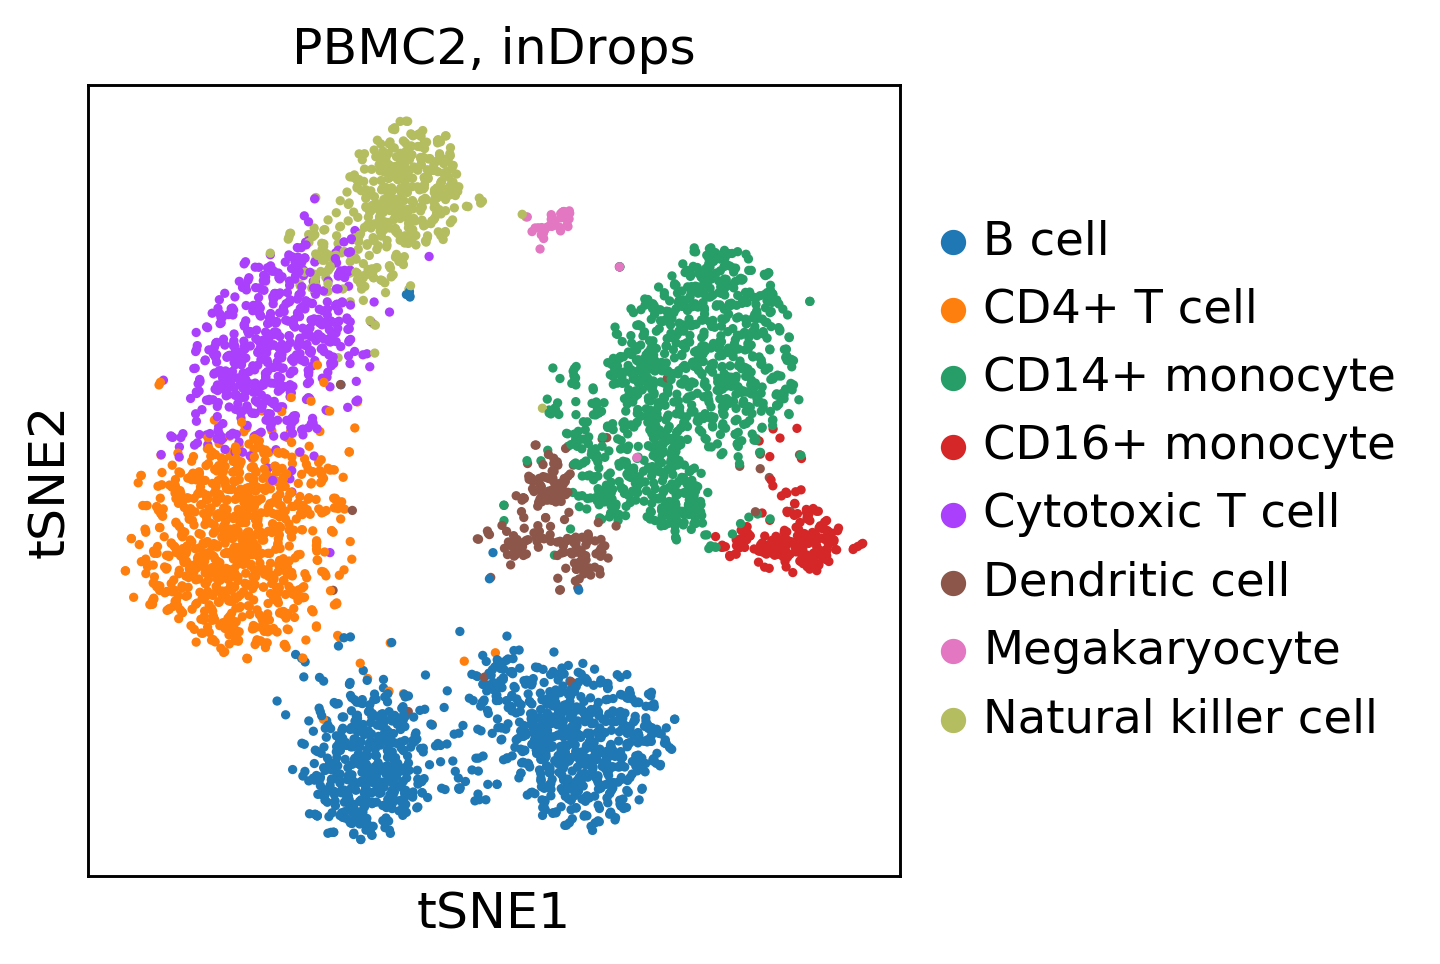

In [55]:
auc = cluster_single_trial(mtx, "PBMC2", "inDrops", cell_type_genes, nn=15, variable_gene=True, reso=1.5, pc=20)

In [46]:
auc

0.8658868190649093

## Search for parameters that optimize AUC

In [ ]:
params = {
    "nn": [5, 10, 15, 30],
    "variable_gene": [True, False],
    "reso": [0.5, 0.8, 1.2, 1.5],
    "pc": [20, 30, 50], 
         }

In [ ]:
import itertools as it
allNames = sorted(params)
combinations = list(it.product(*(params[Name] for Name in allNames)))

In [ ]:
best_auc = 0.0
best_combination = ()
for c in combinations:
    auc = cluster_single_trial(mtx, "PBMC2", "inDrops", 
                               cell_type_genes, nn=c[0], variable_gene=c[3], reso=c[2], pc=c[1])
    if auc >= best_auc:
        best_auc = auc
        best_combination = c